# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 5 — Multivariate and Multi-Output Gaussian Processes

---

Submission by:
* FirstName1, Surname1, Matrikelnummer: MatrikelnummerOfFirstTeamMember
* FirstName2, Surname2, Matrikelnummer: MatrikelnummerOfSecondTeamMember

In [1]:
import functools

import jax
import jax.numpy as jnp
import numpy as np


jax.config.update("jax_enable_x64", True)

In [2]:
from matplotlib import pyplot as plt
from tueplots import bundles
from tueplots.constants.color import rgb


plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 200})

## Exercise 5.2 (Coding Exercise)

In this exercise, we will use Gaussian processes to learn multivariate and vector-valued functions.

In [3]:
from collections.abc import Callable
import dataclasses


@dataclasses.dataclass
class Gaussian:
    # Gaussian distribution with mean mu and covariance Sigma
    mu: jnp.ndarray  # shape (D,)
    Sigma: jnp.ndarray  # shape (D,D)

    @functools.cached_property
    def L_factor(self):
        """Cholesky factorization of the covariance matrix
        (for use in jax.scipy.linalg.cho_solve)"""
        return jax.scipy.linalg.cho_factor(self.Sigma, lower=True)

    def __rmatmul__(self, A):
        """Linear maps of Gaussian RVs are Gaussian RVs
        A: linear map, shape (N,D)
        """
        return Gaussian(mu=A @ self.mu, Sigma=A @ self.Sigma @ A.T)

    @functools.singledispatchmethod
    def __add__(self, other):
        """Affine maps of Gaussian RVs are Gaussian RVs
        shift of a Gaussian RV by a constant.
        We implement this as a singledispatchmethod, because jnp.ndarrays can not be dispatched on,
        and register the addition of two RVs below
        """
        other = jnp.asarray(other)
        return Gaussian(mu=self.mu + other, Sigma=self.Sigma)

    def condition(self, A, y, Lambda):
        """Linear conditionals of Gaussian RVs are Gaussian RVs
        Conditioning of a Gaussian RV on a linear observation
        A: observation matrix, shape (N,D)
        y: observation, shape (N,)
        Lambda: observation noise covariance, shape (N,N)
        """
        Gram = A @ self.Sigma @ A.T + Lambda
        L = jax.scipy.linalg.cho_factor(Gram, lower=True)
        mu = self.mu + self.Sigma @ A.T @ jax.scipy.linalg.cho_solve(L, y - A @ self.mu)
        Sigma = self.Sigma - self.Sigma @ A.T @ jax.scipy.linalg.cho_solve(
            L, A @ self.Sigma
        )
        return Gaussian(mu=mu, Sigma=Sigma)

    @functools.cached_property
    def std(self):
        # standard deviation
        return jnp.sqrt(jnp.diag(self.Sigma))

    def sample(self, key, num_samples=1):
        """
         sample from the Gaussian
        # alternative implementation: works because the @ operator contracts on the second-to-last axis on the right
        # return (self.L @ jax.random.normal(key, shape=(num_samples, self.mu.shape[0], 1)))[...,0] + self.mu
        # or like this, more explicit, but not as easy to read
        # return jnp.einsum("ij,kj->ki", self.L, jax.random.normal(key, shape=(num_samples, self.mu.shape[0]))) + self.mu
        # or the scipy version:
        """
        return jax.random.multivariate_normal(
            key, mean=self.mu, cov=self.Sigma, shape=(num_samples,), method="svd"
        )


@Gaussian.__add__.register
def _add_gaussians(self, other: Gaussian):
    # sum of two Gaussian RVs
    return Gaussian(mu=self.mu + other.mu, Sigma=self.Sigma + other.Sigma)


@dataclasses.dataclass
class GaussianProcess:
    # mean function
    m: Callable[[jnp.ndarray], jnp.ndarray]
    # covariance function
    k: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]

    def __call__(self, x):
        return Gaussian(mu=self.m(x), Sigma=self.k(x[:, None, :], x[None, :, :]))

    def condition(self, y, X, sigma):
        return ConditionalGaussianProcess(
            self, y, X, Gaussian(mu=jnp.zeros_like(y), Sigma=sigma * jnp.eye(len(y)))
        )

    def plot(
        self,
        ax,
        x,
        color=rgb.tue_gray,
        mean_kwargs={},
        std_kwargs={},
        num_samples=0,
        rng_key=None,
    ):
        gp_x = self(x)
        ax.plot(x[:, 0], gp_x.mu, color=color, **mean_kwargs)
        ax.fill_between(
            x[:, 0],
            gp_x.mu - 2 * gp_x.std,
            gp_x.mu + 2 * gp_x.std,
            color=color,
            **std_kwargs
        )
        if num_samples > 0:
            ax.plot(
                x[:, 0],
                gp_x.sample(rng_key, num_samples=num_samples).T,
                color=color,
                alpha=0.2,
            )


class ConditionalGaussianProcess(GaussianProcess):
    """
    A Gaussian process conditioned on data.
    Implented as a proper python class, which allows inheritance from the GaussianProcess superclass:
    A conditional Gaussian process contains a Gaussian process prior, provided at instantiation.
    """

    def __init__(self, prior, y, X, epsilon: Gaussian):
        self.prior = prior
        self.y = jnp.atleast_1d(y)  # shape: (n_samples,)
        self.X = jnp.atleast_2d(X)  # shape: (n_samples, n_inputs)
        self.epsilon = epsilon
        # initialize the super class
        super().__init__(self._mean, self._covariance)

    @functools.cached_property
    def predictive_covariance(self):
        return self.prior.k(self.X[:, None, :], self.X[None, :, :]) + self.epsilon.Sigma

    @functools.cached_property
    def predictive_covariance_cho(self):
        return jax.scipy.linalg.cho_factor(self.predictive_covariance)

    @functools.cached_property
    def representer_weights(self):
        return jax.scipy.linalg.cho_solve(
            self.predictive_covariance_cho,
            self.y - self.prior(self.X).mu - self.epsilon.mu,
        )

    def _mean(self, x):
        x = jnp.asarray(x)
        return (
            self.prior(x).mu
            + self.prior.k(x[..., None, :], self.X[None, :, :])
            @ self.representer_weights
        )

    @functools.partial(jnp.vectorize, signature="(d),(d)->()", excluded={0})
    def _covariance(self, a, b):
        return self.prior.k(a, b) - self.prior.k(
            a, self.X
        ) @ jax.scipy.linalg.cho_solve(
            self.predictive_covariance_cho,
            self.prior.k(self.X, b),
        )

### Task A: Multivariate Gausian Processes - The MathWorks / MATLAB Logo

The lecture mostly focused on Gaussian processes whose input is real-valued.
However, Gaussian processes can be applied to arbitrary inputs, including graphs and images.

Here, we explore multivariate GPs, i.e. the input set $\mathbb{X}$ is a subset of $\mathbb{R}^d$, in particular $d = 2$.

We will use a Gaussian process to reconstruct the Mathworks / MATLAB logo

![MathWorks / MATLAB Logo](https://upload.wikimedia.org/wikipedia/commons/2/21/Matlab_Logo.png)

from a sparse set of measurements.
The logo depicts an [eigenfunction of the wave equation](https://de.mathworks.com/company/newsletters/articles/the-mathworks-logo-is-an-eigenfunction-of-the-wave-equation.html) on an L-shaped domain.

In [4]:
# Load the measurements
data = np.load("matlab_logo.npz")

X = data["X"]
y = data["y"]

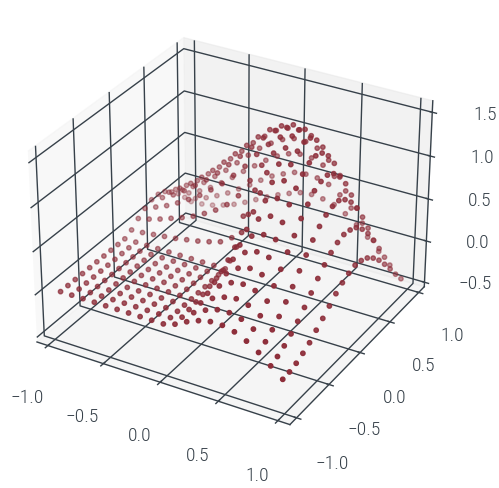

In [5]:
# Visualize the data
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.scatter(
    X[..., 0],
    X[..., 1],
    y,
    marker=".",
    s=10,
)

We can reuse the `(Conditional)GaussianProcess` implementation from the lecture to learn multivariate functions.

However, we need to define a mean function $m \colon \R^2 \to \R$ and a positive definite kernel $k \colon \R^2 \times \R^2 \to \R$, which accept bivariate inputs.

For simplicity, we will choose the mean function to be zero everywhere, i.e. $m(x) = 0$.

In [6]:
def multivariate_zero_mean(x):
    # choose zero everywhere
    # define a mean function $m \colon \R^2 \to \R$
    mean = 0
    return mean * jnp.ones(x.shape[:-1])

There are many different choices for multivariate kernel functions.
Here, we will focus on so-called **radial kernels**, which are of the form
\begin{equation*}
    k(\vec{x}_1, \vec{x}_2) = \tilde{k} \left( \frac{\lVert \vec{x}_1 - \vec{x}_2 \rVert_2}{\ell} \right)
\end{equation*}
for some function $\tilde{k} \colon \mathbb{R}_{\ge 0} \to \mathbb{R}$.

Some of the kernels from the lecture, including the Gaussian, rational quadratic, and Matérn kernels, are radial.
However, the lecture only introduced their 1D versions.
For instance, the multivariate rational quadratic kernel is given by
\begin{align*}
    k_{\alpha, l}(\vec{x}_1, \vec{x}_2)
    & := \tilde{k}_\alpha \left( \frac{\lVert \vec{x}_1 - \vec{x}_2 \rVert_2}{\ell} \right), \quad \text{where} \\
    \tilde{k}_\alpha(r)
    & = \left( 1 + \frac{r^2}{2 \alpha} \right)^{-\alpha}.
\end{align*}

Implement the rational quadratic kernel with $\alpha = 1.0$, $\ell = 0.25$ and an output scale of $\sigma = 0.5$.

In [7]:
def multivariate_rational_quadratic(
    x0,
    x1,
    *,
    alpha=1.0,
    lengthscale=0.25,
    output_scale=0.5,
):
    #Implement the rational quadratic kernel with $\alpha = 1.0$, $\ell = 0.25$ and an output scale of $\sigma = 0.5$.
    # k_{\alpha, l}(\vec{x}_1, \vec{x}_2) = \tilde{k}_\alpha \left( \frac{\lVert \vec{x}_1 - \vec{x}_2 \rVert_2}{\ell} \right), \quad \text{where} \\
    # \tilde{k}_\alpha(r) = \left( 1 + \frac{r^2}{2 \alpha} \right)^{-\alpha}.
    r = jnp.sum(x0 - x1, axis=-1) / lengthscale
    output =  output_scale * (1 + r**2 / (2 * alpha))**(-alpha)
    return output
   

In [8]:
mv_prior = GaussianProcess(
    multivariate_zero_mean,
    multivariate_rational_quadratic,
)

Condition the Gaussian process prior on the training data. Here, we assume no observation noise.

Keep in mind that the inputs `y` and `X` to `GaussianProcess.condition` need to have shape `(n_samples,)` and `(n_samples, n_inputs)`, respectively.

In [9]:
mv_posterior = mv_prior.condition(
    # the inputs `y` and `X` to `GaussianProcess.condition` need to have shape `(n_samples,)` and `(n_samples, n_inputs)`, respectively
    # y has shape (20, 20), but we need to flatten the last two dimensions to get a shape of (400,)
    y=y.flatten(),
    # X has shape (20, 20, 2), but we need to flatten the last two dimensions to get a shape of (400, 2)
    X=X.reshape(-1, 2),
    sigma=0.1,
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Plot the posterior mean in a 3D surface plot.

In [10]:
plt_grid = np.stack(
    np.meshgrid(
        np.linspace(-1, 1, 200),
        np.linspace(-1, 1, 200),
    ),
    axis=-1
)

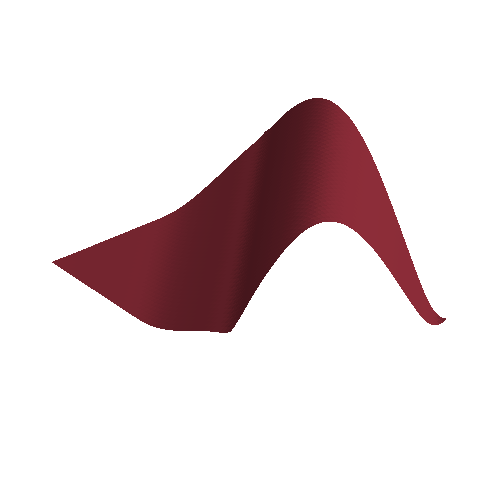

In [11]:
import matplotlib.colors

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

mX = mv_posterior.m(plt_grid)

ax.plot_surface(
    plt_grid[..., 0],
    plt_grid[..., 1],
    mX,
    color="C0",
    lightsource=matplotlib.colors.LightSource(30, 30),
    antialiased=False,
)

ax.set_aspect("equal")
ax.view_init(azim=-40)
ax.set_axis_off()

Plot the posterior standard deviation as a heatmap and superimpose the data points in a scatter plot:

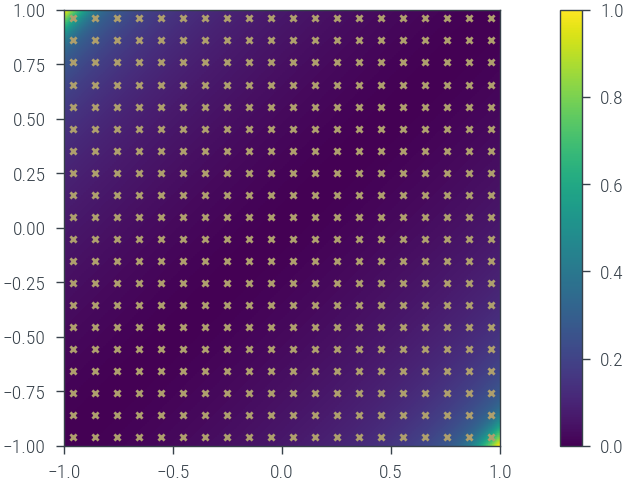

In [12]:
stdX = np.sqrt(mv_posterior.k(plt_grid, plt_grid))

plt.imshow(
    stdX,
    extent=(-1, 1, -1, 1),
)
plt.scatter(
    X[..., 0],
    X[..., 1],
    c="C2",
    marker="x",
    s=5,
)
plt.colorbar()

### Task B: Multi-output Gaussian Processes

In the second part of the exercise, we will construct a GP-based model for a vector-valued function - a so-called **multi-output Gaussian process**.

As a toy example, we will try to track a cargo ship on the ocean after losing communication for 15 minutes.

The trajectory of the ship can be modeled by a function $\vec{s} \colon \mathbb{R}_{\ge 0} \to \mathbb{R}^2$, which maps time to 2D coordinates on a map.

The ship started in a harbor at time $t = 0$ and coordinates $\vec{s}(0) = (0, 0)$.
It receives GPS readings every $\frac{1}{12}$ hours (5 minutes), which have an accuracy of about 5 meters (in the sense of the 95% confidence interval).
We assume the measurement noise to be Gaussian.

However, after 1 hour, we lose communication to the cargo ship.
Your task is to predict the position of the ship after 1.25h using a multi-output Gaussian process.

In [13]:
# Simulate some trajectory data
ts = np.linspace(0., 1.25, 15)  # 1.25h of training data with training points every 5 minutes

ss = np.stack(
    (ts, np.sqrt(ts)),
    axis=-1,
)
# Average speed of cargo ship is 22-37 km/h
ss[1:, :] *= 30. * (ts[1:] / np.cumsum(np.linalg.norm(ss[1:, :] - ss[:-1, :], ord=2, axis=-1)))[:, None]

sigma_train = (0.005 / 1.96)**2 # 5 m accuracy of GPS

# Train / test split
ts_train = ts[:12]
ss_train = ss[:12]

t_test = ts[-1]
s_test = ss[-1]

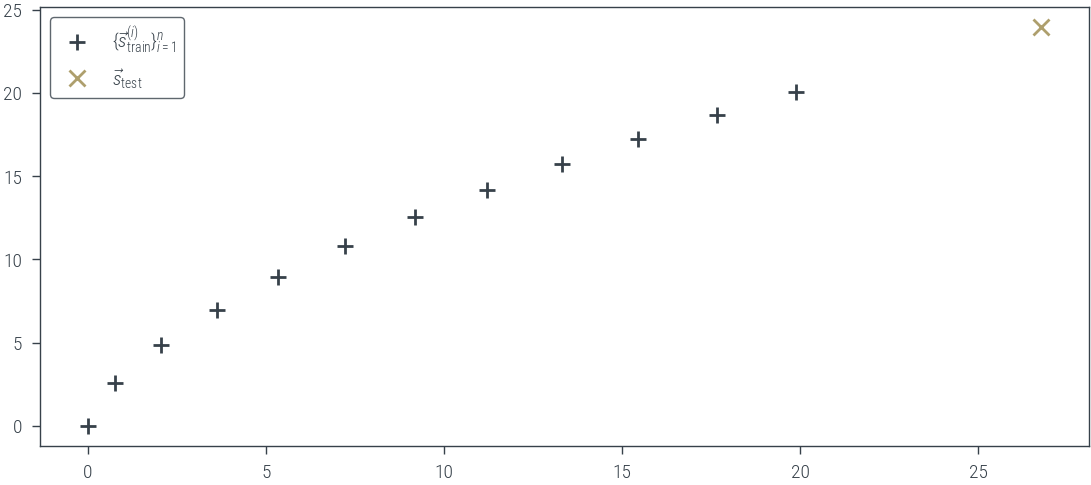

In [14]:
def plot_data(ax=plt.gca()):
    ax.plot(
        ss_train[:, 0],
        ss_train[:, 1],
        "+",
        c="C1",
        label=r"$\{ \vec{s}^{(i)}_\mathrm{train} \}_{i = 1}^n$"
    )

    ax.plot(
        *s_test,
        "x",
        c="C2",
        label=r"$\vec{s}_\mathrm{test}$"
    )

plot_data()
plt.legend()

We need to posit a Gaussian process prior over the unknown trajectory $s \colon \mathbb{R}_{\ge 0} \to \mathbb{R}^2$.

However, since kernel functions are defined to be scalar valued, this generalization is not as straightforward as the generalization to arbitrary inputs.
Fortunately, we can use the fact that Gaussian processes can be defined on arbitrary input sets to "emulate" vector-valued functions.

To this end, note that a function $\vec{f} \colon \mathbb{X} \to \R^d$ is in some sense equivalent to the function

\begin{equation}
    \tilde{f} \colon \{ 1, \dotsc, d \} \times \mathbb{X} \to \R, (i, x) \mapsto \vec{f}_i(x),
\end{equation}

since

\begin{equation}
    \vec{f}(x) =
    \begin{pmatrix}
        \tilde{f}(1, x) \\
        \vdots \\
        \tilde{f}(d, x)
    \end{pmatrix}.
\end{equation}

We can use this equivalence to construct a vector-valued Gaussian process $f \sim \mathcal{GP}(m, k)$.
In this case, the mean function is given by $m \colon \{ 1, \dotsc, d \} \times \mathbb{X} \to \R$ and the kernel function is given by $k \colon (\{ 1, \dotsc, d \} \times \mathbb{X}) \times (\{ 1, \dotsc, d \} \times \mathbb{X}) \to \R$, where $k((i, x_1), (j, x_2))$ computes the covariance between $f_i(x_1)$ and $f_j(x_2)$.

The specific GP prior for the ship tracking problem can be motivated as follows.

We assume that the velocity $\dot{\vec{s}}$ of the ship is well-modeled by two independent Wiener processes (one for each component) with output scales $\sigma_1$ and $\sigma_2$, respectively, and constant mean $\vec{v}_0$.
Then, one can show that $\vec{s} = \int_{0}^t \dot{\vec{s}}(\tau) \mathrm{d}\tau \sim \mathcal{GP}(m, k)$ with

\begin{align*}
    m(i, t) & = (\vec{v}_0)_i t, \qquad \qquad \text{and} \\
    k((i, t_1), (j, t_2))
    & =
    \begin{cases}
        \sigma_i^2 k_\mathrm{IWP}(t_1, t_2) & \text{if } i = j \\
        0                              & \text{otherwise},
    \end{cases}
\end{align*}

where $k_\mathrm{IWP}$ is the integrated Wiener process kernel (a.k.a. cubic spline kernel) from the lecture, i.e.

\begin{equation}
    k_\mathrm{IWP}(t_1, t_2)
    = \frac{1}{3} \operatorname{min}^3(t_1, t_2) + \frac{1}{2} |t_1 - t_2| \operatorname{min}^2(t_1, t_2).
\end{equation}

In [15]:
v0 = (ss_train[1, :] - ss_train[0, :]) / (ts_train[1, None] - ts_train[0, None])

def multi_output_mean(it):
    it = jnp.asarray(it)
    i, t = it[..., 0], it[..., 1]
    i = i.astype(jnp.int_)
    # m(i, t) = (\vec{v}_0)_i t
    mean = v0[i] * t
    return mean

In [16]:
def multi_output_kernel(it0, it1, output_scales=(30.0**2, 30.0**2)):
    it0 = jnp.asarray(it0)
    i0, t0 = it0[..., 0], it0[..., 1]
    i0 = i0.astype(jnp.int_)

    it1 = jnp.asarray(it1)
    i1, t1 = it1[..., 0], it1[..., 1]
    i1 = i1.astype(jnp.int_)

    output_scales = jnp.asarray(output_scales)
    
    def k_IWP(t0, t1):
        # k_\mathrm{IWP}(t0, t1) = \frac{1}{3} \operatorname{min}^3(t0, t1) + \frac{1}{2} |t0 - t1| \operatorname{min}^2(t0, t1)
        return 1. / 3. * jnp.minimum(t0, t1)**3 + 1. / 2. * jnp.abs(t0 - t1) * jnp.minimum(t0, t1)**2

    # k((i0, t_1), (i1, t_2)) = sigma_i0^2 k_\mathrm{IWP}(t_1, t_2) & \text{if } i0 = i1 else 0
    kernel = jnp.where( i0 == i1, output_scales[i0] * k_IWP(t0, t1), 0.0)
    return kernel

In [17]:
s_prior = GaussianProcess(multi_output_mean, multi_output_kernel)

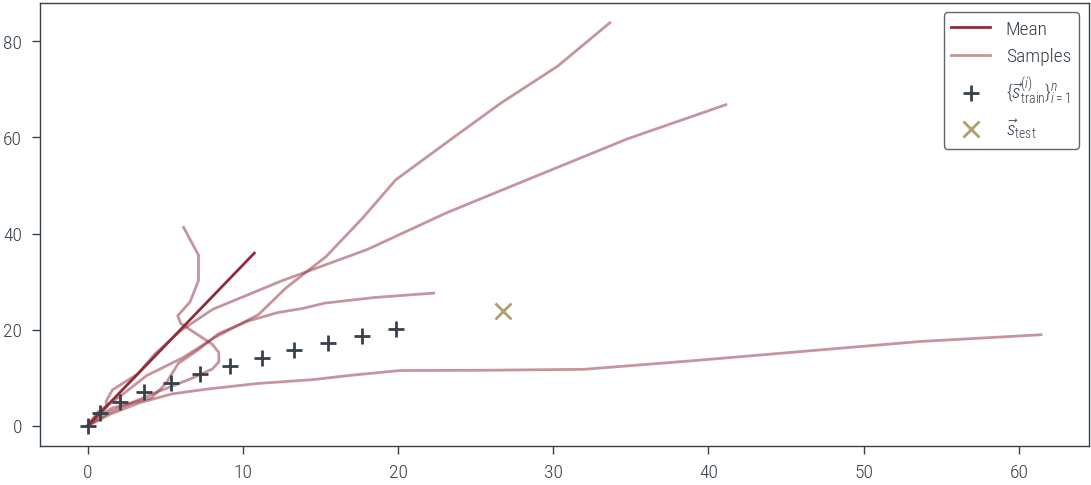

In [18]:
ts_plot = np.linspace(0.0, 1.25, 200)
its_plot = np.stack(
    np.meshgrid(
        [0, 1],
        ts,
        indexing="ij",
    ),
    axis=-1,
)

# GP Mean
m_prior_its_plot = s_prior.m(its_plot)

plt.plot(
    m_prior_its_plot[0, :],
    m_prior_its_plot[1, :],
    c="C0",
    label="Mean",
)

# GP Samples
num_samples = 5
prior_samples = s_prior(its_plot.reshape(-1, 2)) \
                .sample(jax.random.PRNGKey(3), num_samples=num_samples) \
                .reshape(num_samples, 2, -1)

plt.plot(
    prior_samples[:, 0, :].T,
    prior_samples[:, 1, :].T,
    c="C0",
    alpha=0.5,
    label=["Samples"] + [None for _ in range(num_samples - 1)],
)

plot_data(plt.gca())

plt.legend()

Given a training dataset $\mathcal{D} = \{ (t^{(i)}_\text{train}, \vec{s}^{(i)}_\text{train}) \}_{i = 1}^n$, we can use the `(Conditional)GaussianProcess` implementation from the lecture to condition our multi-output GP prior on the augmented dataset

\begin{equation}
    \tilde{\mathcal{D}} = \left\{ \dotsc, \Big( (1, t^{(i)}_\text{train}), (\vec{s}^{(i)}_\text{train})_1 \Big), \Big( (2, t^{(i)}_\text{train}), (\vec{s}^{(i)}_\text{train})_2 \Big), \dotsc \right\}.
\end{equation}

In [19]:
print(ss_train.shape)
print(ts_train.shape)

(12, 2)
(12,)


In [20]:
# Given $\mathcal{D} = \{ (t^{(i)}_\text{train}, \vec{s}^{(i)}_\text{train}) \}_{i = 1}^n$ 
# Augmented dataset is \tilde{\mathcal{D}} = \left\{ \dotsc, \Big( (1, t^{(i)}_\text{train}), (\vec{s}^{(i)}_\text{train})_1 \Big), \Big( (2, t^{(i)}_\text{train}), (\vec{s}^{(i)}_\text{train})_2 \Big), \dotsc \right\}.
ss_train_aug = []
its_train_aug = []
for i in range(ss_train.shape[0]):
    for j in range(ss_train.shape[1]):
        ss_train_aug.append(ss_train[i, j])
        its_train_aug.append((j, ts_train[i]))
ss_train_aug = jnp.array(ss_train_aug)
its_train_aug = jnp.array(its_train_aug)

s_posterior = s_prior.condition(
    ss_train_aug,
    its_train_aug,
    sigma_train,
)

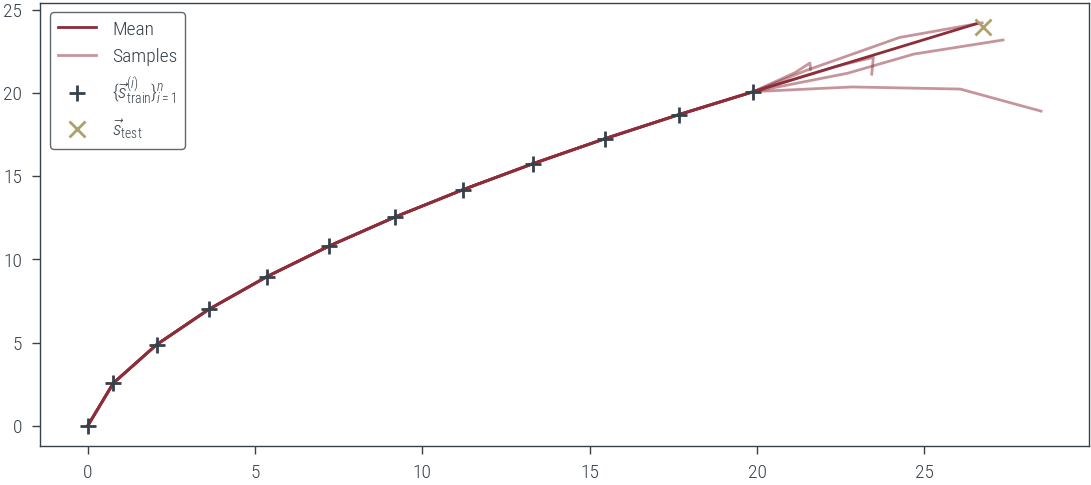

In [21]:
# GP Mean
m_posterior_its_plot = s_posterior.m(its_plot)

plt.plot(
    m_posterior_its_plot[0, :],
    m_posterior_its_plot[1, :],
    c="C0",
    label="Mean",
)

# GP Samples
num_samples = 5
posterior_samples = s_posterior(its_plot.reshape(-1, 2)) \
                    .sample(jax.random.PRNGKey(3), num_samples=num_samples) \
                    .reshape(num_samples, 2, -1)

plt.plot(
    posterior_samples[:, 0, :].T,
    posterior_samples[:, 1, :].T,
    c="C0",
    alpha=0.5,
    label=["Samples"] + [None for _ in range(num_samples - 1)],
)

plot_data(plt.gca())

plt.legend()

Write a function `plot_belief(ax, gp, t, ...)` that visualizes the mean and the 68% and 95% ($1 \sigma$ and $1.96 \sigma$) isoprobability contours of $\vec{s}(t)$.

Hint: If $\vec{s} \sim \mathcal{GP}$, then $\vec{s}(t)$ follows a bivariate normal distribution, whose isoprobability contours are ellipses.

The final plot should look like this:

![Ship Tracking Posterior](ship_tracking_final.png)

In [25]:
def plot_belief(ax, gp, t, color="C0", **kwargs):
    # Visualizes the mean and the 68% and 95% ($1 \sigma$ and $1.96 \sigma$) isoprobability contours of $\vec{s}(t)$.
    # If $\vec{s} \sim \mathcal{GP}$, then $\vec{s}(t)$ follows a bivariate normal distribution, whose isoprobability contours are ellipses.

    # Compute the mean of the GP at time `t`
    t_plot = jnp.array([[(i, t)] for i in range(2)])

    m = gp.m(t_plot)

    ax.plot(
        m[0, :],
        m[1, :],
        marker='o',
        **kwargs,
    )
        

    # Visualize the 68% and 95% ($1 \sigma$ and $1.96 \sigma$) isoprobability contours
    # The isoprobability contours of a bivariate normal distribution are ellipses

    # Compute the covariance of the GP at time `t`
    Sigma = gp.k(t_plot, t_plot)

    x = m[0, :]  # x-position of the center
    y = m[1, :]  # y-position of the center
    std_x = jnp.sqrt(Sigma[0, :])
    std_y = jnp.sqrt(Sigma[1, :])
    a_95 = std_x * 1.96 # 0.95     # radius on the x-axis
    b_95 = std_y * 1.96 # 0.95 # radius on the y-axis
    a_68 = std_x * 1.0  # 0.68   # radius on the x-axis
    b_68 = std_y * 1.0  # 0.68 # radius on the y-axis

    t = np.linspace(0, 2*jnp.pi, 100)
    plt.plot( x+a_95*jnp.cos(t) , y+b_95*jnp.sin(t), color=color, linestyle='-')
    plt.plot( x+a_68*jnp.cos(t) , y+b_68*jnp.sin(t), color=color, linestyle='-')

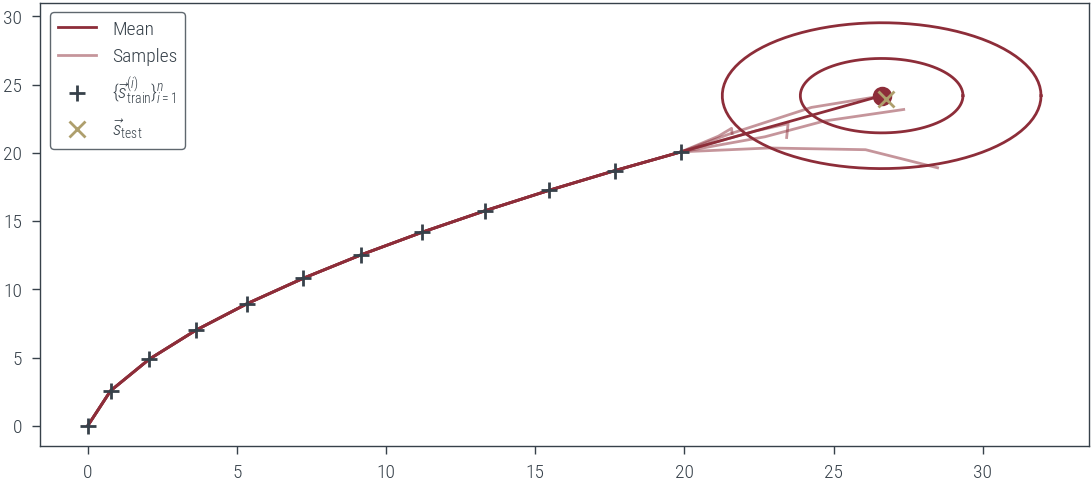

In [26]:
# GP Mean
m_posterior_its_plot = s_posterior.m(its_plot)

plt.plot(
    m_posterior_its_plot[0, :],
    m_posterior_its_plot[1, :],
    c="C0",
    label="Mean",
)

# GP Samples
num_samples = 5
posterior_samples = s_posterior(its_plot.reshape(-1, 2)) \
                    .sample(jax.random.PRNGKey(3), num_samples=num_samples) \
                    .reshape(num_samples, 2, -1)

plt.plot(
    posterior_samples[:, 0, :].T,
    posterior_samples[:, 1, :].T,
    c="C0",
    alpha=0.5,
    label=["Samples"] + [None for _ in range(num_samples - 1)],
)

# Predictive Belief
plot_belief(plt.gca(), s_posterior, t=1.25)

plot_data(plt.gca())

plt.legend()